In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from scipy import optimize
%matplotlib inline

In [2]:
np.random.seed = 420

# Gradient descent method
Since matrix $P$ is given in the problem statement, we will set it uniformly distributed. Let $n = 4$ and $m = 5$.

In [3]:
n = 4
m = 5
P = np.array([np.random.uniform(size=n) for x in np.zeros(m)])
P /= P.sum(axis=0)
c_t = np.array([-np.sum(x * np.log2(x)) for x in P.T])
print(P)

[[ 0.03010262  0.30429777  0.14931357  0.20986587]
 [ 0.01971894  0.38457691  0.26875316  0.15398647]
 [ 0.42623351  0.09273376  0.14989082  0.24481052]
 [ 0.17456529  0.10720182  0.19368007  0.09111684]
 [ 0.34937964  0.11118974  0.23836238  0.30022029]]


In [4]:
def f(x):
    #get projection of x
    x_ = euclidean_proj_simplex(x)
    y = P @ x_
    if (np.min(y) <= 0):
        return np.inf
    return c_t @ x_ + np.sum(y * np.log(y) / np.log(2))

def grad_f(x):
    #get projection of x
    x_ = euclidean_proj_simplex(x)
    y = P @ x_
    if (np.min(y) <= 0):
        raise ValueError
    grad = c_t.copy()
    tmp = []
    for i in range(m):
        tmp.append(P[i] * (np.log(P[i] @ x_) + 1) / np.log(2))
    tmp_sum = np.sum(np.array(tmp), axis=0)
    return grad + tmp_sum

In [5]:
def euclidean_proj_simplex(v, s=1):
    n, = v.shape  
    if v.sum() == s and np.alltrue(v >= 0):
        return v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    theta = (cssv[rho] - s) / (rho + 1.0)
    w = (v - theta).clip(min=0)
    return w

In [6]:
class StoppingCriteria:
    def __init__(self, max_iterations=np.inf, min_grad_norm=0):
        self.max_iterations = max_iterations
        self.min_grad_norm = min_grad_norm
    
    def __call__(self, state):
        cur_iterations = state['iterations']
        cur_grad_norm = np.linalg.norm(state['cur_grad'], ord=2)
        dif_x = np.linalg.norm(state['x'] - state['prev_x'], ord=2)
        return (cur_iterations >= self.max_iterations or cur_grad_norm <= self.min_grad_norm or dif_x <= self.min_grad_norm)

In [7]:
class StepSearchFastestTernary:
    def __init__(self, precision):
        self.precision = precision
        self.left = 0
        self.right = None
        
    def __update_starting_points(self, state, init_kpower=-2):
        k_power = init_kpower
        f = state['f']
        x = state['x']
        dx = state['dx']
        while f(x + 2**k_power * dx) > f(x + 2**(k_power + 1) * dx):
            k_power += 1
        if k_power == init_kpower:
            self.left = 0
        else:
            self.left = 2**(k_power - 1)
        self.right = 2**(k_power + 1)
            
            
    def __call__(self, state):
        f = state['f']
        x = state['x']
        dx = state['dx']
        
        self.__update_starting_points(state) # update self.left and self.right
        
        right = self.right
        left = self.left
        
        while True:
            if abs(right - left) < self.precision:
                return (left + right)/2

            left_div = left + (right - left)/3
            right_div = right - (right - left)/3

            f_left = f(x + left_div * dx)
            f_right = f(x + right_div * dx)
            
            if f_left == np.inf:
                right = right_div
            else:
                if f_left < f_right:
                    right = right_div
                else:
                    left = left_div

In [42]:
class StepSearchBacktracking:
    def __init__(self, alpha=0.3, beta=0.7):
        self.alpha = alpha
        self.beta = beta
            
    def __call__(self, state):
        t = 1
        f = state['f']
        grad_f = state['grad_f']
        x = state['x']
        dx = state['dx']
        grad_proj = euclidean_proj_simplex(grad_f(x))
#         print('left and right ', f(x + t * dx), f(x) + self.alpha * t * grad_proj.T @ (-grad_proj))
        while f(x + t * dx) > f(x) + self.alpha * t * grad_proj.T @ dx:
#             print('left and right ', f(x + t * dx), f(x) + self.alpha * t * grad_proj.T @ (-grad_proj))
            t *= self.beta
        return t

In [43]:
class StepSearchConstant:
    def __init__(self, lr):
        self.lr = lr
            
    def __call__(self, state):
        return self.lr  

In [77]:
class GradientDescentMethod:
    def __init__(self, t_search, stopping_criteria):
        self.t_search = t_search
        self.stopping_criteria = stopping_criteria
    
    def fit(self, f, grad_f, x_0):
        x = x_0.copy()
        state = dict()
        state['f'] = f
        state['grad_f'] = grad_f
        state['x'] = x
        # hardcoded xD
        state['prev_x'] = np.ones(n) / n
        
        state['iterations'] = 0
        state['time'] = time.time()
        state['steps_norms'] = []
        state['time_array'] = []
        while True:
            state['cur_grad'] = grad_f(state['x'])
            state['dx'] = -grad_f(state['x'])
            if self.stopping_criteria(state):
                break
            t = self.t_search(state)
            state['prev_x'] = state['x'].copy()
            state['x'] -= t * state['cur_grad']
            #take projection on simplex
            state['x'] = euclidean_proj_simplex(state['x'])
            state['steps_norms'].append(np.linalg.norm(state['x'] - state['prev_x'], ord=2))
            state['time_array'].append(time.time() - state['time'])
            state['iterations'] += 1
            
        state['time'] = time.time() - state['time']
        return state

In [107]:
search_methods = [StepSearchFastestTernary(precision=1e-7), StepSearchConstant(lr=0.5),
             StepSearchBacktracking(alpha=1e-8, beta=0.5)]
method_names = ['Ternary', 'Constant, lr=0.5', r'Backtracking, $\alpha$=1e-8, $\beta=0.5$']
stopping_criteria = StoppingCriteria(min_grad_norm=1e-12)
grad = GradientDescentMethod(t_search=t_search, stopping_criteria=stopping_criteria)
x_0 = np.random.uniform(low=0, high=1, size=n)
x_0 /= np.sum(x_0)

In [108]:
states = []
for t_search in search_methods:
    grad = GradientDescentMethod(t_search=t_search, stopping_criteria=stopping_criteria)
    state = grad.fit(f, grad_f, x_0)
    states.append(state)

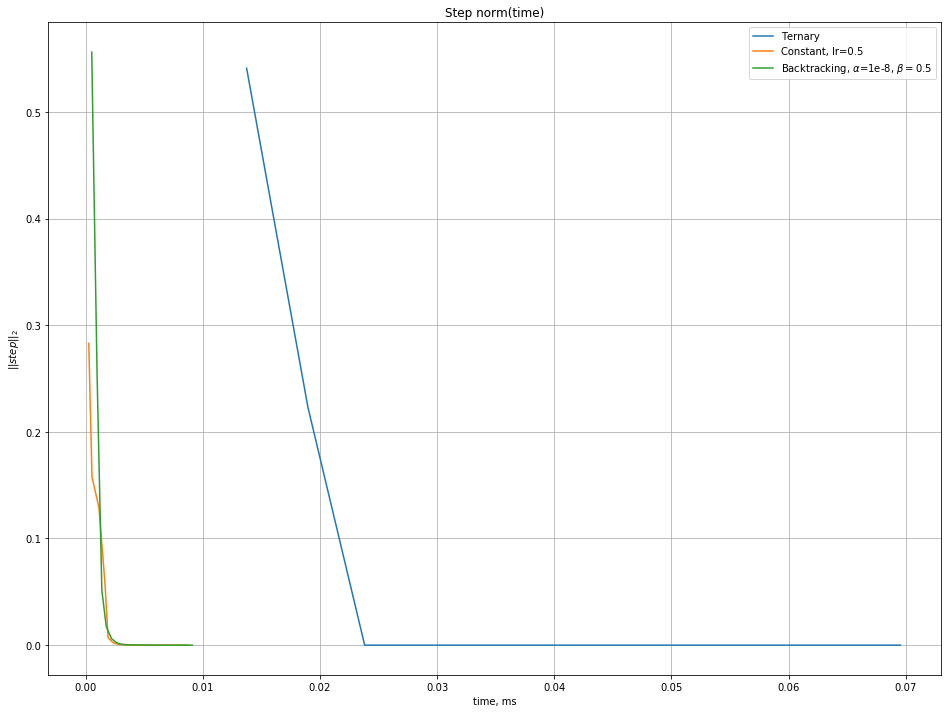

In [109]:
plt.figure(figsize=(16, 12))
plt.grid(True)
plt.title('Step norm(time)')
plt.xlabel('time, ms')
plt.ylabel(r'$||step||_2$')
for state, name in zip(states, method_names):
    plt.plot(state['time_array'], state['steps_norms'], label=name)
plt.legend()

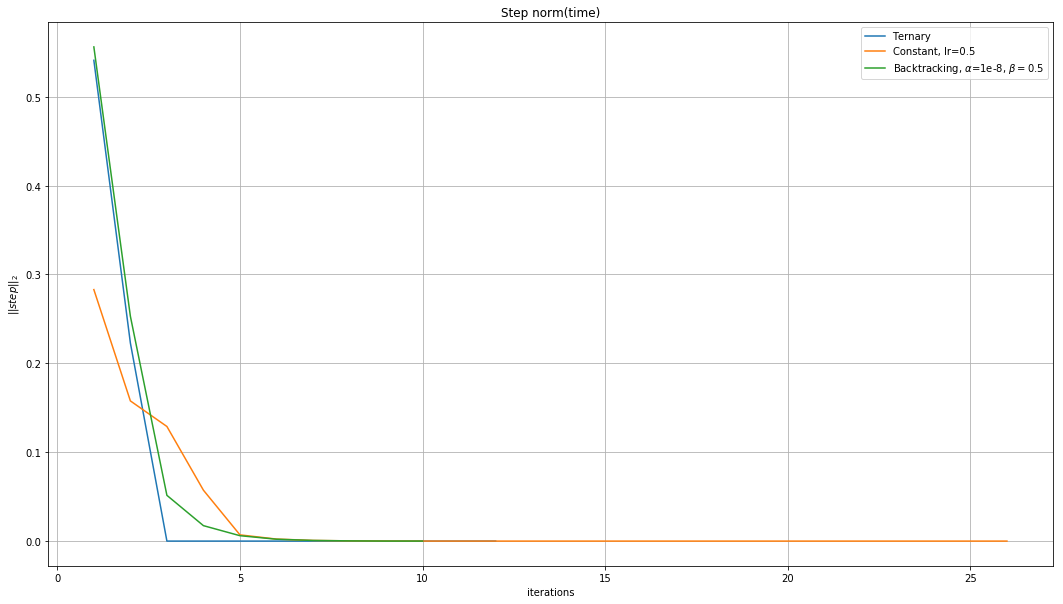

In [115]:
plt.figure(figsize=(18, 10))
plt.grid(True)
plt.title('Step norm(time)')
plt.xlabel('iterations')
plt.ylabel(r'$||step||_2$')
for state, name in zip(states, method_names):
    plt.plot(np.arange(1, len(state['steps_norms']) + 1), state['steps_norms'], label=name)
plt.legend()

In [78]:
stopping_criteria = StoppingCriteria(min_grad_norm=1e-12)
t_search = StepSearchFastestTernary(precision=1e-7)
grad = GradientDescentMethod(t_search=t_search, stopping_criteria=stopping_criteria)
x_0 = np.random.uniform(low=0, high=1, size=n)
x_0 /= np.sum(x_0)
state = grad.fit(f, grad_f, x_0)
print('x_0 = ', x_0)
print('f_min =', f(state['x']))
print('time = ', state['time'])
print("iterations = ", state['iterations'])
print('x = ',state['x'])

x_0 =  [ 0.40206418  0.35333899  0.04970143  0.19489541]
f_min = -0.377917147549
time =  0.09930229187011719
iterations =  13
x =  [ 0.53978498  0.46021502  0.          0.        ]


In [73]:
stopping_criteria = StoppingCriteria(min_grad_norm=1e-12)
t_search = StepSearchConstant(lr=1.2)
grad = GradientDescentMethod(t_search=t_search, stopping_criteria=stopping_criteria)
state = grad.fit(f, grad_f, x_0)
print('x_0 = ', x_0)
print('f_min =', f(state['x']))
print('time = ', state['time'])
print("iterations = ", state['iterations'])
print('x = ',state['x'])

x_0 =  [ 0.2770532   0.06445471  0.32984464  0.32864745]
f_min = -0.377917147549
time =  0.028169870376586914
iterations =  54
x =  [ 0.53978498  0.46021502  0.          0.        ]


In [85]:
stopping_criteria = StoppingCriteria(min_grad_norm=1e-12)
t_search = StepSearchBacktracking(alpha=1e-8, beta=0.5)
grad = GradientDescentMethod(t_search=t_search, stopping_criteria=stopping_criteria)
state = grad.fit(f, grad_f, x_0)
print('x_0 = ', x_0)
print('f_min =', f(state['x']))
print('time = ', state['time'])
print("iterations = ", state['iterations'])
print('x = ',state['x'])

x_0 =  [ 0.40206418  0.35333899  0.04970143  0.19489541]
f_min = -0.377917146497
time =  0.01547694206237793
iterations =  8
x =  [ 0.53981292  0.46018708  0.          0.        ]


In [48]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: x[2]},
       {'type': 'ineq', 'fun': lambda x: x[3]})

In [24]:
print(optimize.minimize(f, x_0, method='SLSQP',
               constraints=cons))

     fun: -0.37791714745771166
     jac: array([ -1.10417604e-05,   1.10417604e-05,   1.97496980e-01,
         2.22076014e-01])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([  5.39776754e-01,   4.60223246e-01,  -6.72205347e-18,
         9.75239854e-17])
